In [ ]:
!nvidia-smi

Sat Mar 13 06:09:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 38kB/s 


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os 
import io
import shutil
import time 
import json
from glob import glob
from PIL import Image
from IPython.display import display 
import pickle
from tqdm import tqdm
import requests
from pickle import dump, load

In [ ]:
# Downloading the Image File and Caption File

# Captions
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'), 
                                           origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+ '/annotations/captions_train2017.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2017/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2017.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2017.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

19336863744/19336861798 [==============================] - 394s 0us/step


In [ ]:
# print('Captions Path: {}\nImage Path: {}'.format(annotation_file,PATH))
annotation_file = '/content/annotations/captions_train2017.json'
PATH = '/content/train2017/'

In [ ]:
with open(annotation_file, 'r') as f:
  annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

for i in range(5):
  print(image_path_to_caption['/content/train2017/000000203564.jpg'][i])

<start> A bicycle replica with a clock as the front wheel. <end>
<start> The bike has a clock as a tire. <end>
<start> A black metal bicycle with a clock inside the front wheel. <end>
<start> A bicycle figurine in which the front wheel is replaced with a clock
 <end>
<start> A clock with the appearance of the wheel of a bicycle  <end>


In [ ]:
image_paths = list(image_path_to_caption.keys())
print(image_paths[:5])
random.shuffle(image_paths)

# Selecting all images from the shuffled set.
# Approximately each image has 5 captions associated with it, so that will
# Lead to num_of_images*5 examples.
train_image_paths = image_paths[:]
print("Total_images:",len(train_image_paths))

['/content/train2017/000000203564.jpg', '/content/train2017/000000322141.jpg', '/content/train2017/000000016977.jpg', '/content/train2017/000000106140.jpg', '/content/train2017/000000571635.jpg']
Total_images: 118287


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A family at the petting zoo with their child <end>


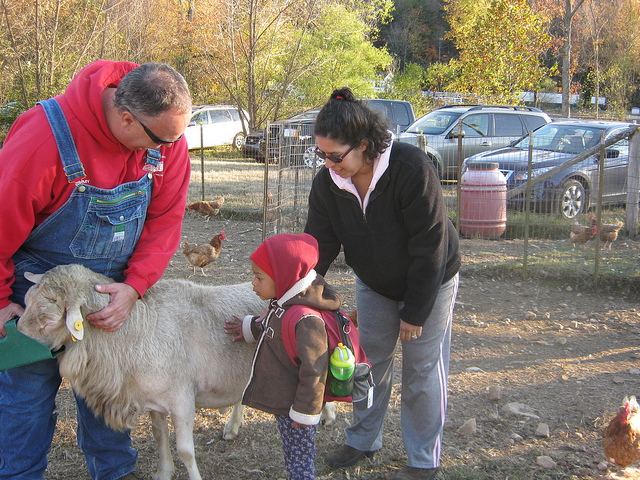

In [ ]:
print(train_captions[0])
#print(img_name_vector[0])
Image.open(img_name_vector[0])

In [ ]:
# Feature Extraction

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Get unique images
encode_train =sorted(set(img_name_vector))

# Batch Size = 16, we can change that according to system config..
batch_size=16
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
#print(image_dataset)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy(), allow_pickle=True)

100%|██████████| 7393/7393 [16:57<00:00,  7.26it/s]


In [ ]:
# Preprocess and Tokenize the captions

def calc_max_length(tensor):
    return max(len(t) for t in tensor)

#top_k = 7700 #27952 #27550
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

vocab_size = len(tokenizer.word_index) + 1
print("Vocab_size: ", vocab_size)

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
print("Max_length: ",max_length) # <<--- Write the max lenght in notes. This will be used in the testing.ipynb

Vocab_size:  27954
Max_length:  52


In [ ]:
# Saving the tokenizer <<----

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

# Copy the tokenizer file in to drive
os.remove("/content/drive/MyDrive/Image-Captioning/tokenizer.pickle")
shutil.copy('tokenizer.pickle', "/content/drive/MyDrive/Image-Captioning")

'/content/drive/MyDrive/Image-Captioning/tokenizer.pickle'

In [ ]:
# Splitting data into train-test
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Creating training and validation sets
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.995)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val =[]
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(588792, 588792, 2961, 2961)

In [ ]:
# Creating tf.data dataset for training

# We can change the batch_size and buffer size according to system config.
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1 #top_k
print(vocab_size)
num_steps = len(img_name_train)

#Shape of the vector extracted from InceptionResNetV2 is (64,2048)
feature_shape = 2048
attention_features_shape = 64

#Load the numpy fiel
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

27954


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Using map to load the numpy in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# This is for removing the save checkopints from the cloud storage
# shutil.rmtree('Train')
# os.mkdir('Train')

In [ ]:
# Model 
class Attention(tf.keras.Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = Attention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
# # Mounting Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
checkpoint_path = "/content/Train"

ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
                                          #step_counter=tf.Variable(1.), checkpoint_interval=30)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint).assert_consumed()

In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
  start = time.time()
  total_loss = 0

  for (batch, (img_tensor, target)) in enumerate(dataset):
    batch_loss, t_loss = train_step(img_tensor, target)
    total_loss += t_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
      # storing the epoch and loss value to plot later
      loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

      print('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
      end = time.time()
      print('Time taken for 1 epoch {} sec\n'.format(end-start))

Streaming output truncated to the last 5000 lines.
Epoch 1 Loss 0.006205
Time taken for 1 epoch 18085.869822502136 sec

Epoch 1 Loss 0.006206
Time taken for 1 epoch 18089.441874980927 sec

Epoch 1 Loss 0.006207
Time taken for 1 epoch 18093.122245788574 sec

Epoch 1 Loss 0.006208
Time taken for 1 epoch 18096.611949443817 sec

Epoch 1 Loss 0.006209
Time taken for 1 epoch 18101.60530924797 sec

Epoch 1 Loss 0.006210
Time taken for 1 epoch 18104.912660121918 sec

Epoch 1 Loss 0.006212
Time taken for 1 epoch 18107.353940725327 sec

Epoch 1 Batch 5100 Loss 0.593485
Epoch 1 Loss 0.006213
Time taken for 1 epoch 18110.86405301094 sec

Epoch 1 Loss 0.006214
Time taken for 1 epoch 18114.511419534683 sec

Epoch 1 Loss 0.006215
Time taken for 1 epoch 18117.597167015076 sec

Epoch 1 Loss 0.006216
Time taken for 1 epoch 18121.36959338188 sec

Epoch 1 Loss 0.006217
Time taken for 1 epoch 18124.787389993668 sec

Epoch 1 Loss 0.006218
Time taken for 1 epoch 18128.45890688896 sec

Epoch 1 Loss 0.006219
T

In [ ]:
# Plotting
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Label')
plt.title('Loss Plot')
plt.show()

In [ ]:
# Loading the tokenizer in the drive  <<----
src = '/content/Train'
dest = "/content/drive/MyDrive/Image-Captioning/Training-Checkpoints"
shutil.rmtree(dest)
os.mkdir(dest)
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, dest)

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# Captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:',' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
# image_url = 'download.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+ image_extension, origin=image_url)
image_path = './download.jpg'
result, attention_plot = evaluate(image_path)
display(Image.open(image_path))

print('Predicted Caption:<start>',' '.join(result))